# ML Course 2023 |  Sentiment Analysis in Twitter Challenge
You can check the updated leaderboard in this [link](https://nimble-hellebore-184.notion.site/ML-Course-2023-Sentiment-Analysis-in-Twitter-Challenge-966b041e7aec4f2eabbc8dc33d64b871).

In [1]:
!pip3 install tueplots==0.0.5
!pip3 install sentence-transformers==2.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=d32f64717ceee93a347414264c1eb02150f523c7561e9b7aa965ecc9caf12c9d
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


# Load Tweets

The dataframe of tweets contain the following columns:

- `id`: The unique identifier of the tweet
- `text`: The content of the tweet
- `type`: The type of tweet, which can be 'tweet', 'quoted', 'retweeted' or 'quoted__replied_to'
- `author_id`: The unique identifier of the author of the tweet
- `possibly_sensitive`: A boolean value indicating whether the tweet contains sensitive content
- `retweet_count`: The number of times the tweet has been retweeted
- `quote_count`: The number of times the tweet has been quoted
- `reply_count`: The number of times the tweet has been replied to
- `like_count`: The number of times the tweet has been liked
- `followers_count`: The number of followers of the author of the tweet
- `following_count`: The number of accounts the author of the tweet is following
- `tweet_count`: The total number of tweets made by the author of the tweet
- `listed_count`: The number of lists the author of the tweet is a member of
- `score_compound`:  A numerical value ranging from -1 to 1 indicating the overall sentiment of the tweet, where -1 represents  negative sentiment and 1 represents positive sentiment. **This is the target variable for the regression task.**
- `sentiment`: A categorical variable indicating the sentiment of the tweet, which can be 'negative', 'neutral' or 'positive'. **This is the target variable for the classification task.**




In [ ]:
import os
import pandas as pd
pd.set_option('display.max_rows', 100)

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
import tueplots.constants.color.palettes as tue_palettes

from sentence_transformers import SentenceTransformer

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#CHANGE THIS PATH FOR YOU
%cd '/content/drive/MyDrive/ML_2023/students'
# %cd '/content/drive/MyDrive/coreML23/ML_2023/students'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1uygN2gmu-IbG_aoX814OVCftq2TIsFy9/ML_2023/students


In [ ]:
team_id = '1' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('tweets_train.csv').sample(100) # we are subsampling 100 training data
df_test = pd.read_csv(f'tweets_{split}.csv').sample(200) # we are subsampling 200 test data


In [ ]:
df[df.type == 'tweet'].head()

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words,score_compound,sentiment
5654,555438389814505472,.@BaiduResearch now has best ImageNet classifi...,tweet,216939636,False,79,0,1,63,744556,670,1510,9898,"['best', 'imagenet', 'classification', 'error']",0.3612,positive
5342,1010365822806646784,Loving the #WorldCup !! So nice to see countri...,tweet,14130366,False,477,24,155,6806,5169451,140,1833,8955,"['loving', 'worldcup', 'nice', 'see', 'countri...",0.9473,positive
1566,1534670676778311680,Excited we're partnering with @figma to bring ...,tweet,14130366,False,218,43,83,2273,5169451,140,1833,8955,"['excited', 'partnering', 'bring', 'collaborat...",0.3400,neutral
5461,334764671808724992,Yale joins Coursera! Courses on Financial Mar...,tweet,216939636,False,8,0,2,7,744556,670,1510,9898,"['yale', 'joins', 'coursera', 'courses', 'fina...",0.0000,neutral
7880,707540472038752257,"Trending globally on twitter no. 3, 6, 7, 9, a...",tweet,1482581556,False,56,0,4,126,282492,99,1468,4681,"['trending', 'globally', 'twitter', 'alphago',...",-0.2960,neutral


In [ ]:
df_test.head()

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words
41,1561704937624506368,As I've said in the past:\nMany of the best id...,quoted,48008938,False,84,6,8,532,427851,582,12949,6488,"['said', 'past', 'many', 'best', 'ideas', 'ai'..."
405,646696272267636736,RT @neiltyson: Sept 23: Happy Equinox to all E...,retweeted,14130366,False,4897,0,0,0,5169451,140,1833,8955,"['sept', 'happy', 'equinox', 'earthlings', 'on..."
198,889855888948740096,Kudos Mark Zuckerberg for speaking out against...,tweet,216939636,False,520,86,84,1170,744556,670,1510,9898,"['kudos', 'mark', 'zuckerberg', 'speaking', 'a..."
928,276437836184576000,Coursera just reached 2 million students (doub...,tweet,216939636,False,66,0,6,12,744556,670,1510,9898,"['coursera', 'reached', 'million', 'students',..."
506,1523430740565786624,RT @CWolberger: Just love this little bit on t...,retweeted,62044012,False,12883,0,0,0,33022,3383,5246,359,"['love', 'little', 'bit', 'mother', 'day', 'ca..."


# Pre-process tweets

The following are the preprocessing steps we followed to get the `words` column from the original tweet, which corresponds to the `text` column of the dataframe.

- Remove punctuations, special characters, mentions, links, and numbers from the tweets.
- Convert all the tweets to lowercase.
- Tokenize the tweets into individual words.
- Remove stop words, such as "and", "the", "a", etc.
- Perform stemming or lemmatization on the remaining words to convert them to their base form.
- Filter out any words that occur infrequently in the corpus to reduce the dimensionality of the data.
- Create a bag of words representation of the tweets, where each tweet is represented as a vector of word frequencies.


**Note:** Lemmatization is a process in natural language processing where words are reduced to their base form, or lemma. This is done by removing inflections, such as pluralization or verb conjugation, and converting the word to its dictionary form. The result of this process is a word that is more easily recognizable, and can be used to improve the accuracy of NLP models, such as the LDA model. By lemmatizing the words in a corpus of text, the dimensionality of the data is reduced, and the relationships between words become clearer, making it easier to identify patterns and themes within the text.


In [ ]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))


# Visualize content of the tweets

Join all of the preprocessed tweets together and create a world cloud of them to see most frequently used words among all tweets.

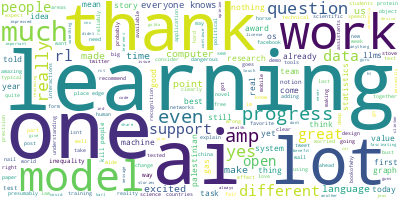

In [ ]:
long_string = ','.join(list(df['words_str'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Sentiment Analysis

**In this part, we will visualize the distribution of these possible sentiments in our dataset.**

Each tweet in our dataset have one of three sentiments (`sentiment`):

*   Positive
*   Neutral
*   Negative

Also, each tweet has a continous score (`score_compound`) between [-1,1] where -1 corresponds to negative and 1 corresponds to a positive sentinement.

In [ ]:
df_pos = df[df.sentiment == 'positive']
df_neu = df[df.sentiment == 'neutral']
df_neg = df[df.sentiment == 'negative']


num_total = len(df)
num_pos = len(df_pos)
num_neu = len(df_neu)
num_neg = len(df_neg)

print(f"Num. positive tweets: {num_pos} ({num_pos/num_total*100:.2f}%)")
print(f"Num. negative tweets: {num_neg} ({num_neg/num_total*100:.2f}%)")
print(f"Num. neutral tweets: {num_neu} ({num_neu/num_total*100:.2f}%)")


Num. positive tweets: 33 (33.00%)
Num. negative tweets: 4 (4.00%)
Num. neutral tweets: 63 (63.00%)


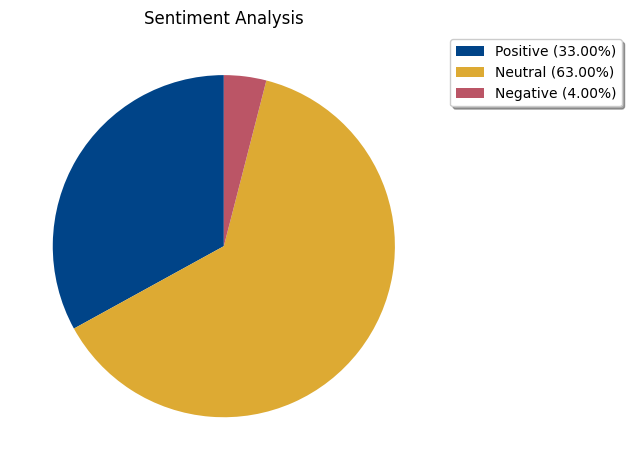

In [ ]:
plt.close('all')

fig, ax = plt.subplots(1, 1)

labels = []
labels.append(f"Positive ({num_pos/num_total*100:.2f}%)")
labels.append(f"Neutral ({num_neu/num_total*100:.2f}%)")
labels.append(f"Negative ({num_neg/num_total*100:.2f}%)")

sizes = [num_pos, num_neu, num_neg]

colors = [f"#{i}" for i in tue_palettes.high_contrast[:3]]

_ = ax.pie(sizes,colors=colors, startangle=90)
# plt.style.use(default’)
ax.legend(labels,
          loc='upper center', 
          bbox_to_anchor=(1.23, 1.0), 
          fancybox=True, 
          shadow=True)

ax.set_title("Sentiment Analysis")
plt.tight_layout()
plt.show()

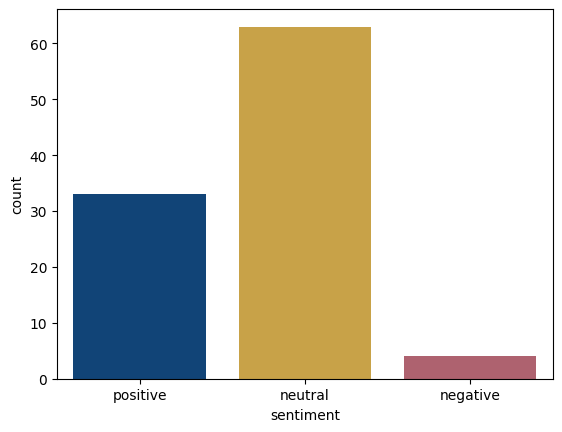

In [ ]:
plt.close('all')

sns.countplot(x=df.sentiment, palette=colors)
plt.show()

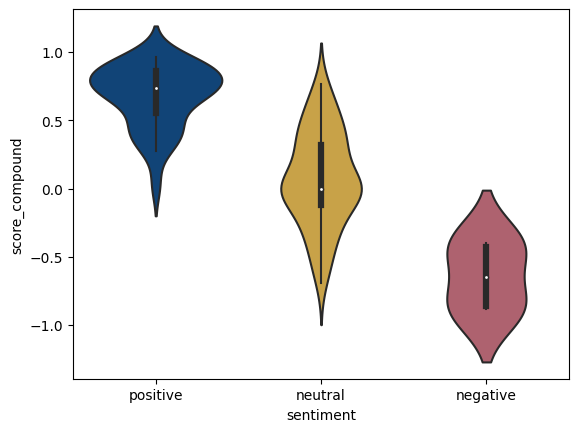

In [ ]:
plt.close('all')

sns.violinplot(data=df, x='sentiment', y='score_compound', palette=colors)
plt.show()

# Obtain the text embeddings

When working with natural language processing tasks, such as text classification, it is common to use word embeddings to represent the meaning of words and sentences. Word embeddings are dense vectors that capture the semantic relationships between words in a way that allows for easier processing by machine learning algorithms.

The process of creating word embeddings involves training a neural network on a large corpus of text data. However, pre-trained word embeddings are readily available online and can be downloaded and used in your projects. See a complete list of pre-trained models [here](https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md). 


**Note:** When working with pre-trained models, it is important to keep in mind the computational resources required to generate the embeddings. Depending on the size of the model and the amount of text data being processed, generating embeddings may take a significant amount of time. Therefore, it is advisable to save the embeddings locally once they have been generated, to avoid the need to re-generate everytime you may want to make changes in the model (but not in the embedding).



In [ ]:
# name = 'stsb-distilbert-base'
name = 'bert-base-nli-mean-tokens'
# name = 'average_word_embeddings_komninos'
model = SentenceTransformer(name)


In [ ]:
sentences = list(df.words_str.values)
sentence_embeddings = model.encode(sentences)

# Linear regression

In this part, we will solve an linear regression task to predict our target `score_compound`, i.e. continous sentiment score of tweets, using our features which are encodings of the tweets.


In [ ]:
#define some functions for plotting purposes

def plot_y_continous(y, bins=10, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.hist(y, bins=bins)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

def plot_scatter(x, y,  show=True, x_label=None, y_label=None,  title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.scatter(x,y)
    if isinstance(title, str):
        ax.set_title(title)
    if isinstance(x_label, str):
        ax.set_xlabel(x_label)
    if isinstance(y_label, str):
        ax.set_ylabel(y_label)
    plt.tight_layout()
    if show: plt.show()
    

In [ ]:
#create X (feature matrix) and y (targets)
X = sentence_embeddings
y = df.score_compound.values
print(f"X: {X.shape}")
print(f"y: {y.shape}")



X: (100, 768)
y: (100,)


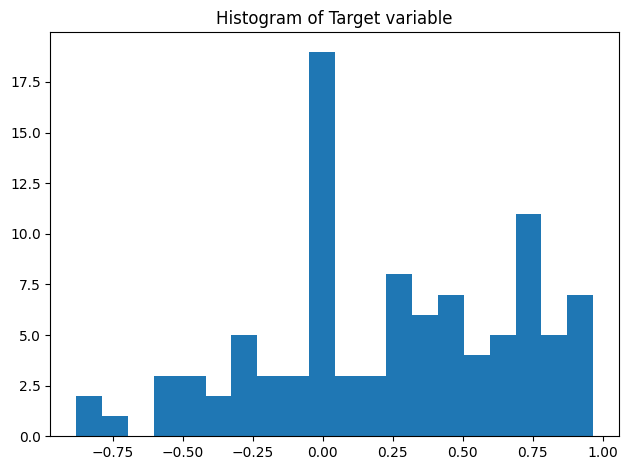

In [ ]:
plt.close('all')
plot_y_continous(y, bins=20, title='Histogram of Target variable')

In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized the cost functions 

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import numpy as np

In [ ]:
#split X and y for training and validation purposes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

#create our linear regression model
reg = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

Now fit a linear regression model on the training data.

In [ ]:
reg = reg.fit(X_train, y_train)

In [ ]:
# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")


Split: train
	RMSE: 0.00
	MAE: 0.00

Split: valididation
	RMSE: 0.41
	MAE: 0.33


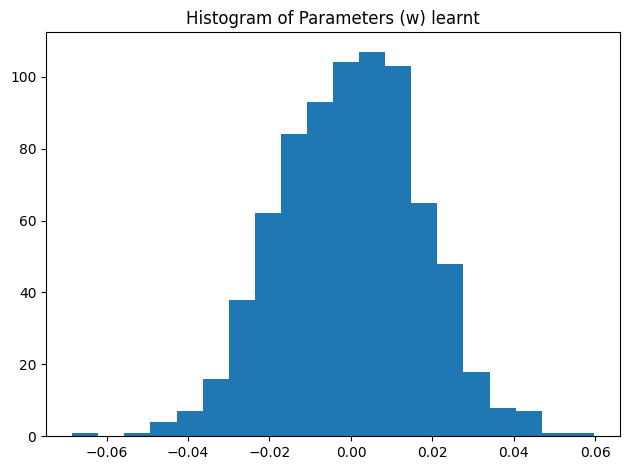

In [ ]:
#plot the histogram of learnt weights w_i 
plot_y_continous(reg.coef_, bins=20, title='Histogram of Parameters (w) learnt')

At this point, we can use our model to predict sentiments scores of tweets from `X_test`, i.e. test set. Do not forget to encode them as well.

And save your predictions `y_hat` by naming it with the following format. 

`<TEAM_ID>__<SPLIT>_reg_pred.npy`

Make sure that

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_1" during the semester and "test_2" for final submission. You will be notified when we need to move to "test_2".

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted

sentences = list(df_test.words_str.values)
X_test = model.encode(sentences)
y_hat = reg.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_reg_pred.npy

folder = '/content/drive/MyDrive/ML_2023/students'
np.save(os.path.join(folder, f'{team_id}__{split}__reg_pred.npy'), y_hat)


# Linear classification

In this part, we will solve a linear classification task to predict our target `sentiment`, i.e. sentiment class of tweets, using our features which are encodings of the tweets.


In [ ]:
from sklearn import linear_model
from sklearn import preprocessing
import numpy as np

In [ ]:
def plot_y_discrete(y, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    sns.countplot(x=y, palette=colors, ax=ax)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

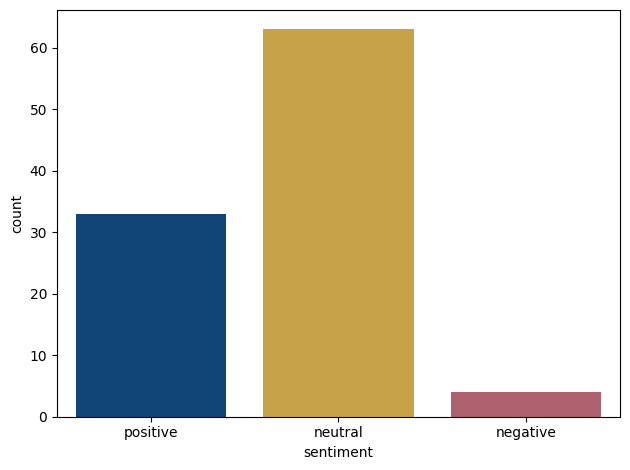

In [ ]:
plot_y_discrete(df.sentiment)

We will first change our targets (classes; positive, neutral, negative) to numeric targets. Then, we solve a logistic regression problem by minimizing the multinomial cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} \mathbb{1}_{y_{i}=k} \log(p_{\theta}(\hat{y}=k | \mathbf{x}_{i}))
$$

where $y_i \in \{1,\ldots,K\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_{i})$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_{i}$.

In [ ]:
X = sentence_embeddings
y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]
clf = linear_model.LogisticRegression(penalty=None, 
                                      dual=False, 
                                      tol=0.0001, 
                                      C=1.0, 
                                      fit_intercept=True, 
                                      intercept_scaling=1, 
                                      class_weight=None, # None, balanced
                                      random_state=None, 
                                      solver='lbfgs', 
                                      max_iter=1000, 
                                      multi_class='auto', 
                                      verbose=0, 
                                      warm_start=False, 
                                      n_jobs=None, 
                                      l1_ratio=None
                                     )

Original classes ['negative' 'neutral' 'positive']
Corresponding numeric classes [0 1 2]
X: (100, 768)
y: (100,) [0 1 2]


Fit your model by using training data.

In [ ]:
clf = clf.fit(X_train, y_train)



Reminders about macro and micro averaging:


In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


Now evaluate your model

In [ ]:
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))


Split: train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        27

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Split: valididation
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.50      0.33      0.40         6

    accuracy                           0.70        20
   macro avg       0.62      0.60      0.60        20
weighted avg       0.68      0.70      0.68        20



At this point, we can use our model to predict sentiments scores of tweets from `X_test`, i.e. test set. Do not forget to encode them as well.

And save your predictions `y_hat` by naming it with the following format. 

`<TEAM_ID>__<SPLIT>_clf_pred.npy`

Make sure that

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_1" during the semester and "test_2" for final submission. You will be notified when we need to move to "test_2".

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
sentences = list(df_test.words_str.values)
X_test = model.encode(sentences)
y_hat = clf.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_clf_pred.npy

folder = '/content/drive/MyDrive/ML_2023/students'
np.save(os.path.join(folder, f'{team_id}__{split}__clf_pred.npy'), y_hat)

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy` \

Above, `<SPLIT>` should correspond to `test_1` for the leaderboard and `test_2` for the final submission. 